In [1]:
# construct initial potential random field

In [525]:
import numpy as np
from scipy.interpolate import interp1d
import time
import redshifts
from math import lgamma
import loginterp
import common as c
import copy
import scipy
from scipy.linalg import cholesky
from scipy import linalg
import healpy as hp
import config as conf
import estim
from estim import estimator
import pyfftlog 
import importlib
import redshifts
import spectra
import matplotlib.pyplot as plt
from math import pi
import config as conf
import my_remote_spectra as remote_spectra
from scipy.interpolate import RegularGridInterpolator
import scipy.stats as stats
import Pk_library as PKL

In [503]:
import param
importlib.reload(param)
# speed of light
c = param.c
# Hubble parameter, kms^-1Mpc^-1
H0 = param.H0
# observable universe radius,14260 Mpc
r_o = param.r_o
# the boundary position of the two bubbles, Mpc
x_c = param.x_c
r_H = c/H0
# initial potential from bubble collision psi_i parametried by A and B, Eq.2.2
# A = 1.e-4 # 1-sigma limit
# B = 1.e-4 # 1-sigma limit

A = param.A
B = param.B
# need a resolution of the 3-d grid?
d = param.d
N = int(2*r_o/d) +1

L = 2*r_o

As= conf.As
ns = conf.ns

print('N=%s' %N)
print('L=%s' %L)
print('A=%s, B=%s' %(A,B))
print('r_H=%s Mpc' %r_H)
print(r'As=%s' %As)
print(r'ns=%s' %ns)

N=31
L=30000
A=0.0001, B=0.0
r_H=4411.764705882353 Mpc
As=2.2
ns=0.965


In [504]:
# 3-d real space axes
x = np.arange(-r_o, r_o+d, d)
y = np.arange(-r_o, r_o+d, d)
z = np.arange(-r_o, r_o+d, d)
# 3-d meshgrid coordinate
# xx, yy = np.meshgrid(x, y)
xx, yy, zz = np.meshgrid(x, y, z)
rr = np.sqrt(xx**2 + yy**2 + zz**2)
# give value to the origin point where r=0
# rr[np.where(rr==0)]=1

In [505]:
# 3-d k-space axes
# k_x = np.arange(-r_o/d, (r_o+d)/d)/(d*N)
# k_y = np.arange(-r_o/d, (r_o+d)/d)/(d*N)
# k_z = np.arange(-r_o/d, (r_o+d)/d)/(d*N)

k_x = np.fft.fftfreq(N)/d
k_y = np.fft.fftfreq(N)/d
k_z = np.fft.fftfreq(N)/d
# 3-d meshgrid k-space coordinate
k_xx, k_yy, k_zz = np.meshgrid(k_x, k_y, k_z)
# as a comparison with np.fft.fftfreq(21, 10)
kk = np.sqrt(k_xx**2 + k_yy**2 + k_zz**2)

k_x_shift, k_y_shift, k_z_shift = np.fft.fftshift(k_x), np.fft.fftshift(k_y), np.fft.fftshift(k_z)
k_xx_shift, k_yy_shift, k_zz_shift = np.meshgrid(k_x_shift, k_y_shift, k_z_shift)

In [506]:
if 0:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.colorbar(ax.scatter(k_xx,k_yy,k_zz, c=kk, s=0.1))
    ax.set_xlabel(r'$k_{x}$')
    ax.set_ylabel(r'$k_{y}$')
    ax.set_zlabel(r'$k_{z}$')
    ax.set_title(r'$k-space$');

In [507]:
# visulizing 3-d potential
if 0:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.colorbar(ax.scatter(xx,yy,zz, s=0.1))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'z')
    ax.set_title(r'$real\ space$');

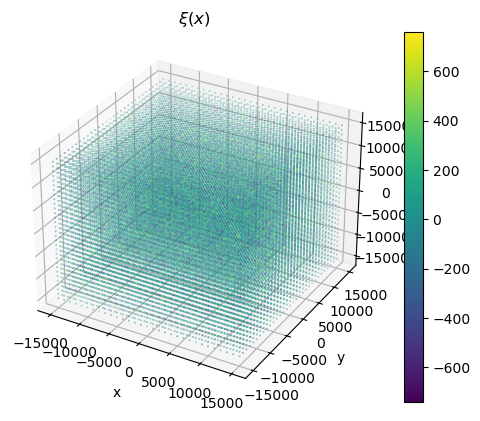

In [508]:
mean = 0
sigma  = np.sqrt(N**3)

xi_x = np.float32(np.random.normal(mean, sigma, (N, N, N)))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.colorbar(ax.scatter(xx,yy,zz,c=xi_x, s=0.1))
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')
ax.set_title(r'$\xi(x)$');

In [509]:
# xi_k = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(xi_x)))
xi_k = np.fft.fftn(xi_x)
if 0:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.colorbar(ax.scatter(k_xx,k_yy,k_zz, c=xi_k.real, s=0.1))
    ax.set_xlabel(r'$k_{x}$')
    ax.set_ylabel(r'$k_{y}$')
    ax.set_zlabel(r'$k_{z}$')
    ax.set_title(r'$\xi(k)$');

In [510]:
xi_x_recover = np.fft.ifftn(xi_k)
if 0:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.colorbar(ax.scatter(xx,yy,zz, c=xi_x_recover, s=0.1))
    ax.set_xlabel(r'$k_{x}$')
    ax.set_ylabel(r'$k_{y}$')
    ax.set_zlabel(r'$k_{z}$')
    ax.set_title(r'$\xi(x)_{recover}$');

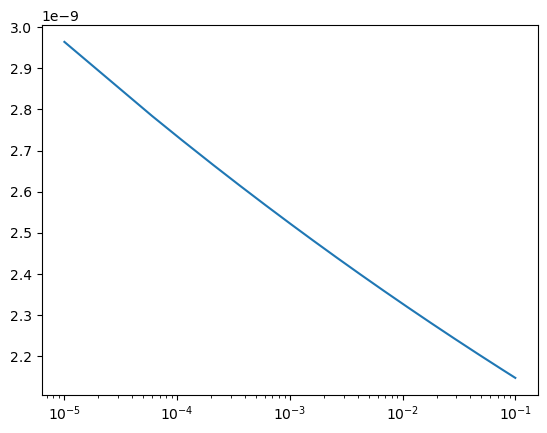

In [580]:
k_test = np.linspace(1e-5, 1e-1, 2000)
k_pivot = 0.05
P_psi_k = As*(k_test/k_pivot)**(ns-1)*1e-9
# P_psi = remote_spectra.Ppsi(k_test, As, ns)
if 1:
    plt.plot(k_test, P_psi_k)
    plt.xscale('log')
F_k = np.sqrt((2*pi/L)**3*P_psi_k)

In [581]:
from scipy.interpolate import interp1d

In [582]:
F_k_itp = interp1d(k_test, F_k, fill_value="extrapolate")

In [606]:
# psi_k = np.reshape(F_k_itp(kk.flatten())*xi_k.flatten(), kk.shape)
psi_k = np.reshape(xi_k.flatten(), kk.shape)

In [607]:
if 0:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.colorbar(ax.scatter(k_xx,k_yy,k_zz,c=psi_k.real, s=0.1))
    ax.set_xlabel(r'x')
    ax.set_ylabel(r'y')
    ax.set_zlabel(r'z')
    ax.set_title(r'$\Psi (k)$');

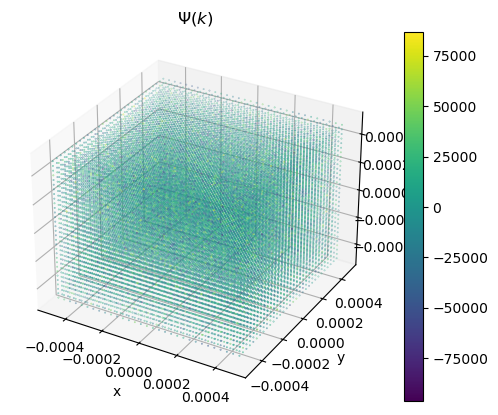

In [608]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
psi_k_shift = np.fft.fftshift(psi_k)
    
fig.colorbar(ax.scatter(k_xx_shift,k_yy_shift,k_zz_shift,c=psi_k_shift.real, s=0.1))
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')
ax.set_title(r'$\Psi (k)$');

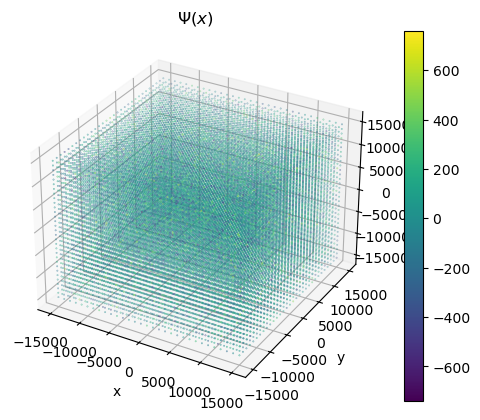

In [609]:
psi_x = np.fft.ifftn(psi_k)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.colorbar(ax.scatter(xx,yy,zz,c=psi_x.real, s=0.1))
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')
ax.set_title(r'$\Psi (x)$');

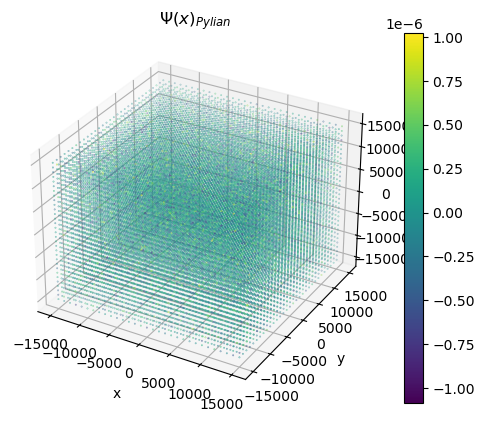

In [610]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

fig.colorbar(ax.scatter(xx,yy,zz,c=df_3D, s=0.1))
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')
ax.set_title(r'$\Psi (x)_{Pylian}$');

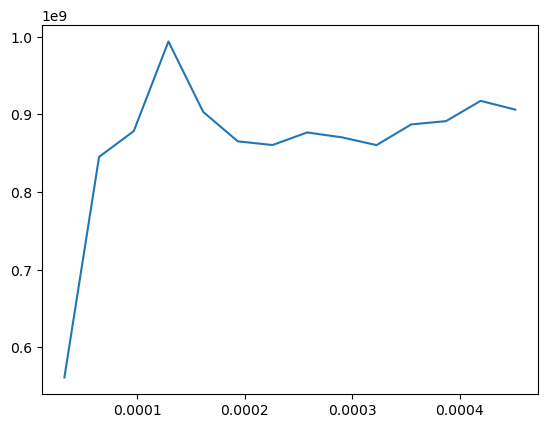

In [627]:
# check P_psi_k https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
psi_k_amplitude = np.abs(psi_k)**2

k_mid = (k_x[:len(k_x)//2+1][:-1]+k_x[:len(k_x)//2+1][1:])/2
kbins = np.linspace(1e-4, 1e-2, 100)
kbins = k_mid

psi_k_amplitude = np.abs(np.fft.fftshift(psi_k))**2
Abins, _, _ = stats.binned_statistic(kk.flatten(), psi_k_amplitude.flatten(),
                                     statistic = "mean",
                                     bins = kbins)
kvals = 0.5 * (kbins[1:] + kbins[:-1])

# Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
# Abins *= 4. * np.pi / 3. * (kbins[1:]**3 - kbins[:-1]**3)
plt.plot(kvals, Abins)
# plt.xscale('log')
# plt.plot(k_test, P_psi_k)